<a href="https://colab.research.google.com/github/armstrohiro/Openpose/blob/main/Openpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given video.

Please read the [OpenPose license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) before running this script.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#ColabのセッションにGoogle Driveがマウントされ、Google Drive内のファイルやディレクトリにアクセスできるようになる。

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'
#osモジュールを使ってパスを設定しています。OPENPOSE_PATHはOpenPoseのインストールされたディレクトリのパスを指定し、HOME_PATHはスクリプトが実行されるディレクトリのパスを指定する。

In [ ]:
!echo $HOME_PATH

./


##Install OpenPose

In [ ]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))


# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote
#OpenPoseがセットアップされ、MP4形式の動画ファイルを表示するための準備が整います。

Submodule '3rdparty/caffe' (https://github.com/CMU-Perceptual-Computing-Lab/caffe.git) registered for path '3rdparty/caffe'
Submodule '3rdparty/pybind11' (https://github.com/pybind/pybind11.git) registered for path '3rdparty/pybind11'
Cloning into '/content/openpose/3rdparty/caffe'...
Cloning into '/content/openpose/3rdparty/pybind11'...
Submodule path '3rdparty/caffe': checked out '2d4bf549aabf97265f76b9599b82540dde9218ed'
Submodule path '3rdparty/pybind11': checked out '06e8ee2e357fc2fd6e36de431fa0ca0049aafc7d'


Workaround for server problem (run if you see `file DOWNLOAD HASH mismatch` when building OpenPose):

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh" -O models.zip && rm -rf /tmp/cookies.txt
#指定されたGoogle Drive上のファイルのダウンロードリンクからファイルをダウンロードし、その後models.zipという名前で保存します。
#このコマンドは、Colab内でGoogle Driveからファイルをダウンロードする際によく使われる。

--2025-03-11 03:56:47--  https://docs.google.com/uc?export=download&confirm=&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh
Resolving docs.google.com (docs.google.com)... 142.250.101.139, 142.250.101.100, 142.250.101.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download [following]
--2025-03-11 03:56:47--  https://drive.usercontent.google.com/download?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2422 (2.4K) [text/html]
Saving to: ‘models.zip’

models.zip          100%[===================>]   2.37K  --.-KB/s    in 0s      


In [ ]:
#@title
# Workaround for server connection problem ("file DOWNLOAD HASH mismatch"),see, e.g.,
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/1602#issuecomment-641653411
!apt-get install unzip

# !wget -O models.zip  --no-check-certificate -r 'https://drive.google.com/uc?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download'
!unzip -o models.zip -d openpose
#olab上でOpenPoseのモデルファイルをダウンロードし、解凍するためのもの
#OpenPoseのモデルファイルがColabの環境に展開され、OpenPoseを使用して姿勢推定や動作認識を行う準備が整う。

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Archive:  models.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of models.zip or
        models.zip.zip, and cannot find models.zip.ZIP, period.


In [ ]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt
#特定のスクリプトや関数の実行を無効にし、ダウンロードが失敗したリンクを使用しないようにします

In [ ]:
! ls -lha /usr/lib/x86_64-linux-gnu
#/usr/lib/x86_64-linux-gnuディレクトリ内のファイルとディレクトリの一覧が表示され、詳細を確認できます。

total 4.3G
drwxr-xr-x  1 root root  4.0K Mar 11 03:29 .
drwxr-xr-x  1 root root  4.0K Mar  7 14:16 ..
drwxr-xr-x  2 root root  4.0K Mar  7 14:16 atlas
drwxr-xr-x  1 root root  4.0K Mar  7 14:15 audit
drwxr-xr-x  2 root root  4.0K Mar  7 14:15 avahi
drwxr-xr-x  2 root root  4.0K Jul 10  2024 bfd-plugins
drwxr-xr-x  2 root root  4.0K Mar  7 14:16 blas
drwxr-xr-x  2 root root  4.0K Mar  7 14:16 caca
drwxr-xr-x  3 root root  4.0K Mar  7 14:16 ceph
drwxr-xr-x  1 root root  4.0K Mar 11 03:29 cmake
-rw-r--r--  1 root root  1.8K Jan 28 20:25 crt1.o
-rw-r--r--  1 root root  1.2K Jan 28 20:25 crti.o
-rw-r--r--  1 root root   760 Jan 28 20:25 crtn.o
drwxr-xr-x  2 root root  4.0K Mar  7 14:16 dri
drwxr-xr-x  2 root root  4.0K Jun 27  2024 e2fsprogs
drwxr-xr-x  1 root root  4.0K Mar  7 14:15 engines-3
drwxr-xr-x  4 root root  4.0K Mar  7 14:16 fortran
drwxr-xr-x  1 root root   12K Mar  7 14:15 gconv
-rw-r--r--  1 root root  2.5K Jan 28 20:25 gcrt1.o
drwxr-xr-x  2 root root  4.0K Mar  7 14:16 gdalpl

In [ ]:
!cd openpose && rm -rf build || true && mkdir build
#OpenPoseのビルド用のディレクトリがリセットされ、再度ビルドを行う準備が整います

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file
#OpenPoseのビルド設定が変更され、Python関連の機能が有効になります

In [ ]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`
#OpenPoseがCUDAを使用するか、CPUのみを使用するかに応じて、ビルドされたバージョンを取得できます

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.5") 
-- Building with CUDA.
-- CUDA detected: 12.5
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

# Try on sample video

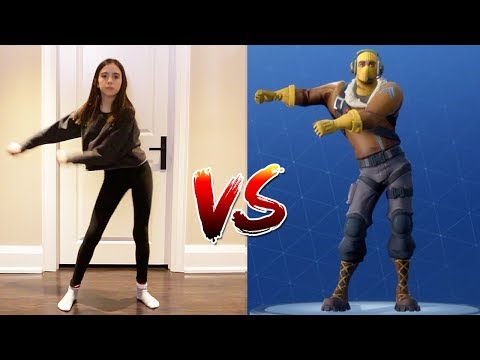

In [ ]:
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'RXABo9hm8B8'
YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [ ]:
# ! sudo -H pip install --upgrade youtube-dl
! pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"
#Colab環境などのPython実行環境でyoutube-dlを最新のバージョンに更新するため

  Cloning https://github.com/ytdl-org/youtube-dl.git to /tmp/pip-req-build-p9h_g9i2
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /tmp/pip-req-build-p9h_g9i2
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit 420d53387cff54ea1fccca061438d59bdb50a39c
  Preparing metadata (setup.py) ... done
  Created wheel for youtube_dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1975951 sha256=f8eb7f0e435c9d6b41c011d8da89dc516c1845692716305d544dfa177c0d7bb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqm0w40x/wheels/91/cb/b5/629bb9aeb351f550a453ee0e4cccdea4c8cf4a16074cb0bd4e
Successfully built youtube_dl
  Attempting uninstall: youtube_dl
    Found existing installation: youtube_dl 2021.12.17
    Uninstalling youtube_dl-2021.12.17:
      Successfully uninstalled youtube_dl-2021.12.17


In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
#YouTubeから動画をダウンロードし、ダウンロードした動画の最初の5秒を切り取るためのもの

[youtube] RXABo9hm8B8: Downloading webpage
[youtube] RXABo9hm8B8: Downloading TVHTML5 API JSON
ERROR: Sign in to confirm you’re not a bot
This helps protect our community. Learn more
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --e

**/content/openpose/models/pose/body_25の配下に<br>
[pose_iter_584000.caffemodel](https://github.com/foss-for-synopsys-dwc-arc-processors/synopsys-caffe-models/blob/master/caffe_models/openpose/caffe_model/pose_iter_584000.caffemodel)というファイルをローカルからアップロードしてから以下を実行**
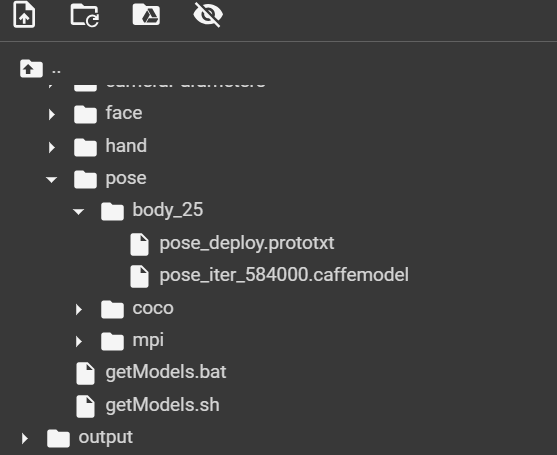

In [ ]:
# detect poses on the these 5 seconds
!cd $OPENPOSE_PATH && rm ../openpose.avi
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4
#5秒間の動画からポーズが検出され、その結果がビデオファイルに保存されます。

rm: cannot remove '../openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (873) open OpenCV | GStreamer warning: Error opening bin: syntax error
[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (616) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created

Error:
VideoCapture (IP camera/video) could not be opened for path: '../video.mp4'. If it is a video path, is the path correct?

Coming from:
- /content/openpose/src/openpose/producer/videoCaptureReader.cpp:VideoCaptureReader():54
- /content/openpose/src/openpose/producer/videoCaptureReader.cpp:VideoCaptureReader():58
- /content/openpose/src/openpose/producer/producer.cpp:createProducer():475
- /content/openpose/include/openpose/wrapper/wrapperAuxiliary.hpp:configureThreadManager():1221
- /content/openpose/include/openpose/wrapper/wrapper.hpp:exec():424
ffmpeg version 4.4.2-0ubu

In [ ]:
# detect poses on the these 5 seconds
!cd $OPENPOSE_PATH && rm ../openpose.avi
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../00006.mp4 --write_json ./output/00006json --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4
#/content/に解析したいファイルを入れる。
#指定された動画（00018.mp4）の5秒間におけるポーズを検出し、その結果をビデオファイルに書き込むためのもの

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 40.946377 seconds.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbi


Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)
#この関数を使うと、output.mp4という名前の動画ファイルが指定された幅と高さで表示されます。

In [ ]:
!zip -r /content/file.zip /content/openpose/output/00005json


  adding: content/openpose/output/00005json/ (stored 0%)
  adding: content/openpose/output/00005json/00005_000000000218_keypoints.json (deflated 51%)
  adding: content/openpose/output/00005json/00005_000000000221_keypoints.json (deflated 51%)
  adding: content/openpose/output/00005json/00005_000000000118_keypoints.json (deflated 51%)
  adding: content/openpose/output/00005json/00005_000000000160_keypoints.json (deflated 52%)
  adding: content/openpose/output/00005json/00005_000000000319_keypoints.json (deflated 52%)
  adding: content/openpose/output/00005json/00005_000000000365_keypoints.json (deflated 51%)
  adding: content/openpose/output/00005json/00005_000000000060_keypoints.json (deflated 52%)
  adding: content/openpose/output/00005json/00005_000000000313_keypoints.json (deflated 53%)
  adding: content/openpose/output/00005json/00005_000000000156_keypoints.json (deflated 52%)
  adding: content/openpose/output/00005json/00005_000000000125_keypoints.json (deflated 51%)
  adding: con

In [ ]:
import os
import json
import pandas as pd
import re

def extract_keypoints_from_all_frames(json_folder, output_csv):
    keypoints_data = []

    # ディレクトリが存在するか確認
    if not os.path.exists(json_folder):
        print(f"Error: Directory '{json_folder}' not found.")
        return

    # JSONファイルのリストを取得し、フレーム番号に基づいてソート
    json_files = sorted([f for f in os.listdir(json_folder) if f.endswith('.json')],
                        key=lambda x: int(re.search(r'(\d+)', x).group(1)))

    # 各JSONファイルから必要なキーポイントを抽出してリストに格納
    for json_file in json_files:
        json_path = os.path.join(json_folder, json_file)

        with open(json_path, 'r') as f:
            data = json.load(f)
            for person in data['people']:
                keypoints = person['pose_keypoints_2d']

                # 各関節のx, y座標を取得
                right_ear = keypoints[18*3:18*3+2]
                left_ear = keypoints[17*3:17*3+2]
                right_shoulder = keypoints[2*3:2*3+2]
                left_shoulder = keypoints[5*3:5*3+2]
                right_elbow = keypoints[3*3:3*3+2]
                left_elbow = keypoints[6*3:6*3+2]
                right_wrist = keypoints[4*3:4*3+2]
                left_wrist = keypoints[7*3:7*3+2]
                hip = keypoints[8*3:8*3+2]
                right_knee = keypoints[9*3:9*3+2]
                left_knee = keypoints[12*3:12*3+2]
                right_ankle = keypoints[10*3:10*3+2]
                left_ankle = keypoints[13*3:13*3+2]
                right_toe = keypoints[22*3:22*3+2]
                left_toe = keypoints[19*3:19*3+2]

                # 各関節のx, y座標をリストに追加
                specific_keypoints = (right_ear + left_ear + right_shoulder + left_shoulder +
                                      right_elbow + left_elbow + right_wrist + left_wrist +
                                      hip + right_knee + left_knee + right_ankle + left_ankle +
                                      right_toe + left_toe)
                keypoints_data.append([json_file] + specific_keypoints)

    # 列名を指定してデータフレームに変換
    columns = ['frame',
               'right_ear_x', 'right_ear_y',
               'left_ear_x', 'left_ear_y',
               'right_shoulder_x', 'right_shoulder_y',
               'left_shoulder_x', 'left_shoulder_y',
               'right_elbow_x', 'right_elbow_y',
               'left_elbow_x', 'left_elbow_y',
               'right_wrist_x', 'right_wrist_y',
               'left_wrist_x', 'left_wrist_y',
               'hip_x', 'hip_y',
               'right_knee_x', 'right_knee_y',
               'left_knee_x', 'left_knee_y',
               'right_ankle_x', 'right_ankle_y',
               'left_ankle_x', 'left_ankle_y',
               'right_toe_x', 'right_toe_y',
               'left_toe_x', 'left_toe_y']

    # データフレームを作成
    df = pd.DataFrame(keypoints_data, columns=columns)

    # フレームの番号を抽出する関数
    def extract_frame_number(frame_name):
        match = re.search(r'(\d+)', frame_name)
        return int(match.group(1)) if match else -1

    # フレーム番号を新しい列として追加
    df['frame_number'] = df['frame'].apply(extract_frame_number)

    # フレーム番号でソート
    df_sorted = df.sort_values(by='frame_number')

    # フレーム番号列を削除
    df_sorted = df_sorted.drop(columns=['frame_number'])

    # ソートされたデータフレームを新しいCSVファイルに保存
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df_sorted.to_csv(output_csv, index=False)
    print(f'Specific keypoints saved to {output_csv}')

# 使用例
json_folder = '/content/openpose/output/00015json'  # JSONファイルが格納されているディレクトリのパス
output_csv = '/content/output/keypoints_15.csv'  # 出力先のCSVファイルパス
extract_keypoints_from_all_frames(json_folder, output_csv)

Specific keypoints saved to /content/output/keypoints_15.csv
